In [ ]:
!nvidia-smi

Thu Jun  9 09:46:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7038133881876622408
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1571100875574898149
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Dense, Input

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow
import numpy as np
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet, MobileNetV2, xception, MobileNetV3Large, mobilenet_v3
from tensorflow.keras.models import load_model

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import backend as k 
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [ ]:
from glob import glob

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung'

Mounted at /content/gdrive
/content/gdrive/My Drive/LDS8_K275_ONLINE_DinhVietTrung


In [ ]:
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [ ]:
# # detect the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # tìm thông tin TPU
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# strategy = tf.distribute.experimental.TPUStrategy(tpu)

### **Transfer Learning**

In [ ]:
img_width, img_height = 299, 299
train_data_dir = 'data/data_food_non_food/train'
test_data_dir = 'data/data_food_non_food/test'

# train_data_dir = 'data/small_data_food_non_food/train'
# test_data_dir = 'data/small_data_food_non_food/test'

In [ ]:
model = applications.InceptionV3(weights = 'imagenet',
                           include_top = False, # whether to include the 3 fully-connected layers at the top network
                           input_shape = (img_width, img_height, 3))

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
lst_layers = []
for layer in model.layers[:]:
    lst_layers.append(layer.name)

df_layers = pd.DataFrame(lst_layers, columns=['layer'])
df_layers

,layer
0,input_1
1,conv2d
2,batch_normalization
3,activation
4,conv2d_1
...,...
306,activation_85
307,mixed9_1
308,concatenate_1
309,activation_93


In [ ]:
247/3

82.33333333333333

In [ ]:
# freeze ~1/3 first layers of Inception
for layer in model.layers[:99]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

### **Build head for CNN**


In [ ]:
folders = glob('data/data_food_non_food/train/food/*')
# folders = glob('/content/gdrive/MyDrive/LDS8_K275_ONLINE_DinhVietTrung/data/small_data_food_non_food/train/food/*')

len(folders)

5072

In [ ]:
# adding custom layers - ANN
x = model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.4)(x)
x = BatchNormalization()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

predictions = Dense(2, activation="softmax")(x)

In [ ]:
final_model = Model(inputs = model.input, outputs = predictions)

In [ ]:
# complile model
final_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

In [ ]:
# !unzip data/small_data_food_non_food.zip -d data/

In [ ]:
# Initiate the train and test generators with data Augumentation 
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   fill_mode = "nearest",
                                   zoom_range = 0.3,
                                   width_shift_range = 0.3,
                                   height_shift_range=0.3,
                                   rotation_range=30)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
batchSize = 64


In [ ]:
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    batch_size = batchSize, 
                                                    class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(test_data_dir,
                                                    target_size = (img_height, 
                                                                   img_width),
                                                    batch_size = batchSize, 
                                                    class_mode = "categorical")


Found 10146 images belonging to 2 classes.
Found 2531 images belonging to 2 classes.


In [ ]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("/content/gdrive/MyDrive/LDS8_K275_ONLINE_DinhVietTrung/LDS8_K275_DinhVietTrung_Cuoi_ky/model/food_nonfood_checkpoint_Inception_V3.h5", 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             save_freq=1)

early = EarlyStopping(monitor='val_loss', 
                      min_delta=0.0001, 
                      patience=15, #20 
                      verbose=1, 
                      mode='auto', 
                      restore_best_weights=True)            

In [ ]:
import datetime
t0 = datetime.datetime.now()

In [ ]:
history = final_model.fit(train_generator,
                          validation_data = validation_generator,
                          batch_size = batchSize,
                          epochs = 100,
                          shuffle=True,
                          callbacks = [checkpoint, early],
                          verbose=1)

Epoch 1/100
159/159 [==============================] - 7616s 48s/step - loss: 0.2496 - accuracy: 0.9164 - val_loss: 997.9915 - val_accuracy: 0.5061
Epoch 2/100
159/159 [==============================] - 276s 2s/step - loss: 0.1605 - accuracy: 0.9421 - val_loss: 0.2596 - val_accuracy: 0.9269
Epoch 3/100
159/159 [==============================] - 275s 2s/step - loss: 0.1320 - accuracy: 0.9516 - val_loss: 0.2735 - val_accuracy: 0.9589
Epoch 4/100
159/159 [==============================] - 278s 2s/step - loss: 0.0973 - accuracy: 0.9650 - val_loss: 0.1315 - val_accuracy: 0.9475
Epoch 5/100
159/159 [==============================] - 277s 2s/step - loss: 0.1024 - accuracy: 0.9651 - val_loss: 0.1512 - val_accuracy: 0.9712
Epoch 6/100
159/159 [==============================] - 283s 2s/step - loss: 0.0887 - accuracy: 0.9693 - val_loss: 0.0742 - val_accuracy: 0.9735
Epoch 7/100
159/159 [==============================] - 282s 2s/step - loss: 0.0849 - accuracy: 0.9708 - val_loss: 0.0857 - val_accur

In [ ]:
t1 = datetime.datetime.now()
t1 - t0

datetime.timedelta(seconds=14948, microseconds=958894)

In [ ]:
print(t1-t0)

4:09:08.958894


In [ ]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
23,0.048136,0.983737,0.086113,0.981035
24,0.043314,0.984822,0.705721,0.814698
25,0.053549,0.982160,0.088519,0.976294
26,0.044117,0.984822,0.107519,0.973133
27,0.042416,0.984329,0.097857,0.967997


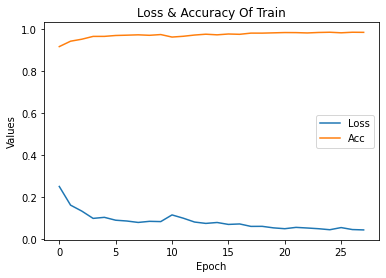

In [ ]:
# loss và acc của train
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Loss & Accuracy Of Train')
plt.ylabel('Values')
plt.xlabel('Epoch')
plt.legend(['Loss', 'Acc'])
plt.show()

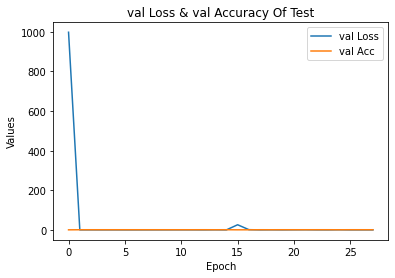

In [ ]:
# loss và acc của test
plt.figure()
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title('val Loss & val Accuracy Of Test')
plt.ylabel('Values')
plt.xlabel('Epoch')
plt.legend(['val Loss', 'val Acc'])
plt.show()

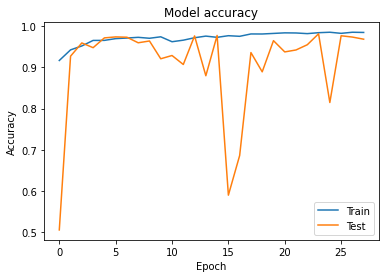

In [ ]:
plt.figure()
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

model cho ra kết quả cao, ko bị overfitting

In [ ]:
final_model.evaluate(train_generator)

159/159 [==============================] - 238s 1s/step - loss: 0.0802 - accuracy: 0.9705


[0.08016306161880493, 0.9705302715301514]

In [ ]:
final_model.evaluate(validation_generator)

40/40 [==============================] - 21s 513ms/step - loss: 0.0651 - accuracy: 0.9759


[0.06512705981731415, 0.9758988618850708]

acc của train và loss đều rất cao, loss nhỏ
=> model tốt

### **Save Model**

In [ ]:
# # save model
from tensorflow.keras.models import load_model
# Creates a HDF5 file 'my_model_CNN_new.h5'
final_model.save('LDS8_K275_DinhVietTrung_Cuoi_ky/model/food_non_food_Inception_V3.h5')
print("save!!!")

save!!!


In [ ]:
%pwd

'/content/gdrive/MyDrive/LDS8_K275_ONLINE_DinhVietTrung'

In [ ]:
from tensorflow.keras.models import load_model
inception_model = load_model('LDS8_K275_DinhVietTrung_Cuoi_ky/model/food_non_food_Inception_V3.h5')

### **Model Architecture**

In [ ]:
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

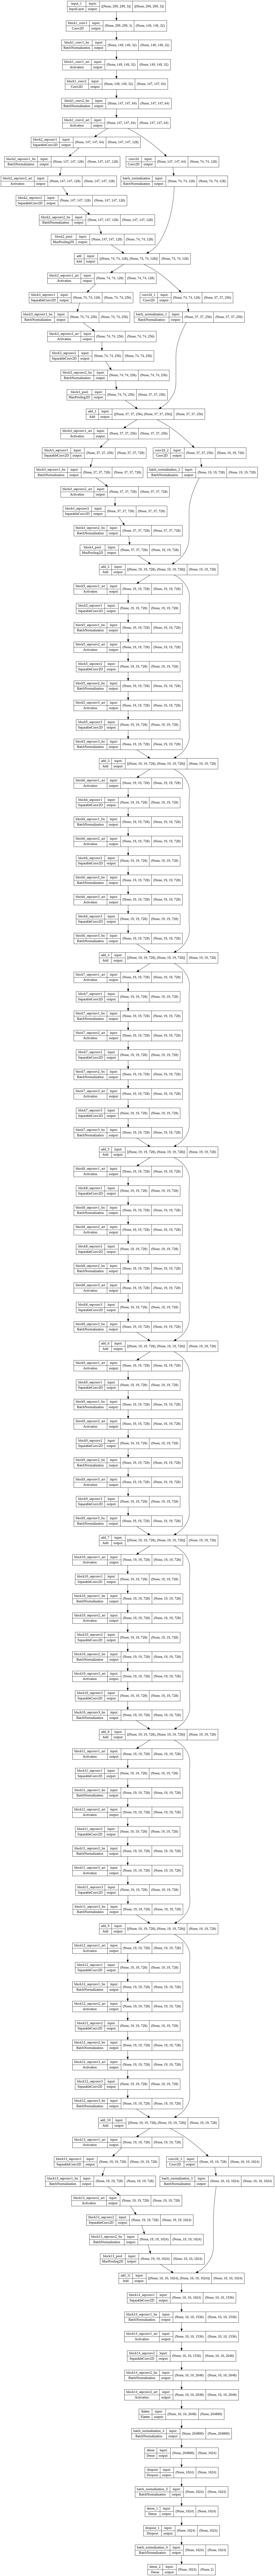

In [ ]:
plot_model(final_model, show_shapes=True)

In [ ]:
import matplotlib.image as mpimg
def show_result(path, model, img_size):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    plt.show()


    test_image = image.load_img(path, target_size = img_size) 


    test_image = image.img_to_array(test_image)
    print(test_image.shape)
    test_image = test_image/255
    test_image = np.expand_dims(test_image, axis = 0)
    print(test_image.shape)
    result = model.predict(test_image)
    result = np.matrix.round(result, 4)
    print(result)

    #training_set.class_indices
    if result[0][0] > result[0][1]:
        prediction = 'Food'
    else:
        prediction = 'NonFood'
    print(prediction)


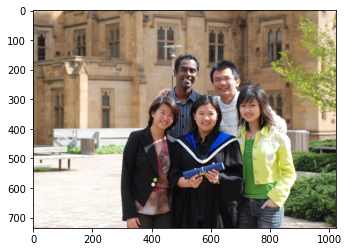

(299, 299, 3)
(1, 299, 299, 3)
[[0. 1.]]
NonFood


In [ ]:
path = 'data/data_food_non_food/evaluation/0_19.jpg'
show_result(path, inception_model, (img_width, img_height))

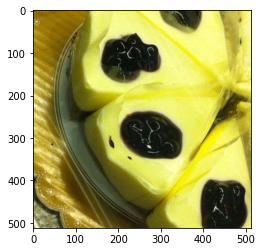

(299, 299, 3)
(1, 299, 299, 3)
[[0.9983 0.0017]]
Food


In [ ]:
path = 'data/data_food_non_food/evaluation/1_20.jpg'
show_result(path, inception_model, (img_width, img_height))

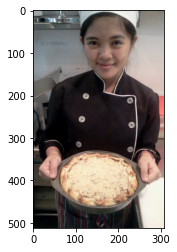

(299, 299, 3)
(1, 299, 299, 3)
[[0.6376 0.3624]]
Food


In [ ]:
path = 'data/data_food_non_food/evaluation/1_19.jpg'

# path = 'data/data_food_non_food/train/food/f_100.jpg'

# show_result(path, inception_model, (img_width, img_height))
show_result(path, inception_model, (img_width, img_height))

In [ ]:
'''
đối với hình vừa có người (một trong những obj là Non Food) và Food, model đưa ra kết quả dựa vào xác suất khá hợp lý
=> tốt
'''

'\nđối với hình vừa có người (một trong những obj là Non Food) và Food, model đưa ra kết quả dựa vào xác suất khá hợp lý\n=> tốt\n'

### **Đánh giá**

so với CNN ở question 3: acc của cả train và test được cải thiện rất nhiều nhờ vào InceptionV3 (~98%), loss cũng rất nhỏ
=> model tốt, tuy nhiên dung lượng hơi nặng (khoảng 1.7GB)